# Single Hidden Layer Neural Network Implementation from Scratch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1oHEewWubrrvavp3eUSUIFhNVTaf28usN)

## Project Overview

Implementation of a single hidden layer neural network from scratch using TensorFlow's core operations for CIFAR-10 airplane classification. This project demonstrates fundamental deep learning concepts including forward propagation, backpropagation, Xavier weight initialization, and gradient-based optimization without using high-level neural network APIs.

## Contributors
- Abolfazl Ranjbar - [GitHub](https://github.com/ImRanjbar)
- Miaad Kimiagari - [GitHub](https://github.com/Miaad2004)
- Taha Najaf - [GitHub](https://github.com/taha-najaf)

## Objectives

- Implement single hidden layer neural network using TensorFlow primitives
- Apply binary classification to CIFAR-10 dataset (airplane vs. non-airplane)
- Demonstrate forward and backward propagation algorithms from first principles
- Implement Xavier weight initialization for optimal training dynamics
- Evaluate model performance and visualize training progression

## Technical Architecture

**Network Structure**: Input Layer → Hidden Layer (64 neurons) → Output Layer (1 neuron)  
**Activation Function**: Sigmoid for both hidden and output layers  
**Loss Function**: Binary Cross-Entropy with numerical stability  
**Optimization**: Mini-batch Gradient Descent with backpropagation  
**Weight Initialization**: Xavier/Glorot initialization for improved convergence  
**Implementation**: TensorFlow core operations (no Keras layers)

## Dataset Preparation and Preprocessing

Loading CIFAR-10 dataset and converting the multi-class problem into binary classification (airplane vs. non-airplane). The preprocessing pipeline includes pixel normalization to [0,1] range and image flattening for fully connected network compatibility.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.utils import to_categorical


# CIFAR
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train, y_test = y_train.flatten(), y_test.flatten()

# preprocess
y_train_bin = (y_train == 0).astype(int)
y_test_bin = (y_test == 0).astype(int)

# normalize and flatten
x_train_flat = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test_flat = x_test.reshape(x_test.shape[0], -1) / 255.0


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


## Neural Network Architecture Implementation

Complete neural network class implementing forward propagation, backpropagation, and training algorithms. The architecture includes Xavier weight initialization, sigmoid activation functions, mini-batch processing, and comprehensive loss tracking for performance monitoring.

In [4]:
import tensorflow as tf
from tqdm.notebook import tqdm, trange

class NN:
    def __init__(self, n_hidden_neurons):
        self.n_neurons = n_hidden_neurons
        self.W_l1 = None
        self.b_l1 = tf.zeros((1, self.n_neurons), dtype=tf.float32)
        self.W_l2 = None
        self.b_l2 = tf.zeros((1, 1), dtype=tf.float32)

        self.loss_history = []
        self.acc_history = []

    @staticmethod
    def loss(y, y_hat):
        eps = 1e-10
        return -tf.reduce_mean(y * tf.math.log(y_hat + eps) + (1 - y) * tf.math.log(1 - y_hat + eps))

    @staticmethod
    def loss_backward(y, y_hat):
        return y_hat - y

    @staticmethod
    def xavier_init(n_in, n_out):
        std = tf.sqrt(2.0 / (n_in + n_out))
        return tf.random.normal((n_in, n_out), stddev=std)

    @staticmethod
    def sigmoid(x):
        return tf.math.sigmoid(x)

    @staticmethod
    def sigmoid_backward(x):
        return x * (1 - x)

    def fp(self, x):
        z1 = tf.matmul(x, self.W_l1) + self.b_l1
        a1 = self.sigmoid(z1)

        z2 = tf.matmul(a1, self.W_l2) + self.b_l2
        a2 = self.sigmoid(z2)

        return a1, a2

    def bp(self, x, y, y_hat, a1):
        m = tf.cast(tf.shape(x)[0], tf.float32)

        # L2
        delta2 = self.loss_backward(y, y_hat)
        dw2 = tf.matmul(tf.transpose(a1), delta2) / m
        db2 = tf.reduce_sum(delta2, axis=0, keepdims=True) / m

        # L1
        delta1 = tf.matmul(delta2, tf.transpose(self.W_l2)) * self.sigmoid_backward(a1)
        dw1 = tf.matmul(tf.transpose(x), delta1) / m
        db1 = tf.reduce_sum(delta1, axis=0, keepdims=True) / m

        return {'dw1': dw1, 'db1': db1, 'dw2': dw2, 'db2': db2}

    def fit(self, X, y, epochs=20, lr=0.1, batch_size=64, shuffle=True):
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.float32)
        y = tf.reshape(y, (-1, 1))

        n_samples, n_features = X.shape
        self.W_l1 = self.xavier_init(n_features, self.n_neurons)
        self.b_l1 = tf.zeros((1, self.n_neurons), dtype=tf.float32)
        self.W_l2 = self.xavier_init(self.n_neurons, 1)
        self.b_l2 = tf.zeros((1, 1), dtype=tf.float32)

        idx = tf.range(n_samples)

        for epoch in trange(epochs, desc="Training Epochs"):
            if shuffle:
                idx = tf.random.shuffle(idx)

            losses = []
            batch_progress = trange(0, n_samples, batch_size, leave=False, desc=f"Epoch {epoch+1}")
            for start in batch_progress:
                end = start + batch_size
                batch_idx = idx[start:end]
                xb = tf.gather(X, batch_idx)
                yb = tf.gather(y, batch_idx)

                a1, a2 = self.fp(xb)
                grads = self.bp(xb, yb, a2, a1)

                self.W_l2 -= lr * grads['dw2']
                self.b_l2 -= lr * grads['db2']
                self.W_l1 -= lr * grads['dw1']
                self.b_l1 -= lr * grads['db1']

                loss = self.loss(yb, a2)
                losses.append(loss.numpy())

                batch_progress.set_postfix({"loss": f"{loss.numpy():.4f}"})

            avg_loss = tf.reduce_mean(losses).numpy()
            y_pred_all = self.predict(X)
            acc = tf.reduce_mean(tf.cast(tf.equal(y_pred_all, tf.cast(y, tf.int32)), tf.float32)).numpy()

            self.loss_history.append(avg_loss)
            self.acc_history.append(acc)

        self.plot_history()

    def predict(self, X):
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        _, a2 = self.fp(X)
        return tf.cast(a2 > 0.5, tf.int32)

    def plot_history(self):
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.loss_history, label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss History')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(self.acc_history, label='Accuracy', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy History')
        plt.grid(True)

        plt.tight_layout()
        plt.show()



## Model Training and Optimization

Training the neural network with 64 hidden neurons using mini-batch gradient descent. The training process includes real-time loss monitoring, accuracy tracking, and automatic visualization of training dynamics across 50 epochs.

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/196 [00:00<?, ?it/s]

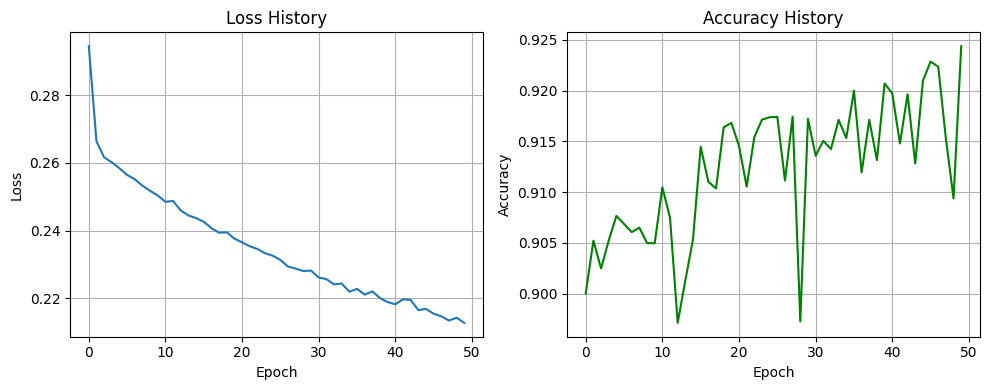

In [5]:
nn = NN(n_hidden_neurons=64)
nn.fit(x_train_flat, y_train_bin, 50, 0.1, 256)

## Performance Evaluation and Model Analysis

Comprehensive evaluation of the trained neural network on test data including loss computation, confusion matrix analysis, and classification metrics. The evaluation demonstrates the effectiveness of the from-scratch implementation compared to traditional machine learning approaches.

Test Loss: 0.4495
Confusion Matrix:
[[8852  148]
 [ 615  385]]

F1 Score: 0.502283105022831
Accuracy: 0.9237


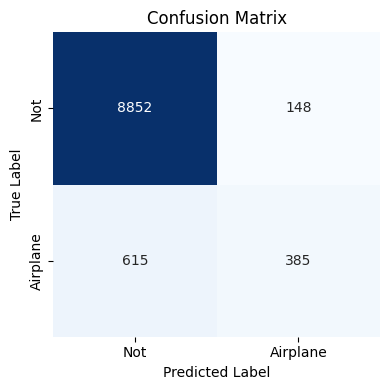

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

# test data to tensor
x_test_flat = tf.convert_to_tensor(x_test_flat, dtype=tf.float32)

# Forward pass and loss
test_probs = nn.fp(x_test_flat)[1]
test_loss = nn.loss(tf.convert_to_tensor(y_test_bin, dtype=tf.float32), test_probs)
print(f"Test Loss: {test_loss:.4f}")

test_preds = nn.predict(x_test_flat).numpy().flatten()

# Evaluation metrics
cm = confusion_matrix(y_test_bin, test_preds)
f1 = f1_score(y_test_bin, test_preds)
acc = accuracy_score(y_test_bin, test_preds)

print("Confusion Matrix:")
print(cm)

print("\nF1 Score:", f1)
print("Accuracy:", acc)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Not", "Airplane"], yticklabels=["Not", "Airplane"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
